In [1]:
# Allow importing from the code directory.
import sys
sys.path.append('../code/')

In [2]:
import pandas as pd
import numpy as np

from etch import load_census

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

import xgboost
import shap

import matplotlib.pyplot as plt

In [3]:
# Load the census dataset.
census = load_census(codes=False)


In [4]:
nominal = census.nominal_features.copy()
continuous = census.continuous_features.copy()
continuous.remove("instance weight")

In [5]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(census.y_train)
y_test_encoded = encoder.transform(census.y_test)

In [6]:
X_train = census.X_train.copy().drop(columns=["instance weight"], axis=1)
X_test = census.X_test.copy().drop(columns=["instance weight"], axis=1)

In [7]:
encoder = OrdinalEncoder()
encoder.fit(X_train[nominal]);

In [8]:
X_train_encoded = pd.concat([
    pd.DataFrame(encoder.transform(X_train[nominal]), columns=nominal),
    pd.DataFrame(X_train[continuous], columns=continuous)
], axis=1)[X_train.columns]

X_test_encoded = pd.concat([
    pd.DataFrame(encoder.transform(X_test[nominal]), columns=nominal),
    pd.DataFrame(X_test[continuous], columns=continuous)
], axis=1)[X_test.columns]


In [9]:
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2, random_state=42).fit(X_train_encoded, y_train_encoded)

explainer = shap.Explainer(model, X_train_encoded)
shap_values = explainer(X_test_encoded)

 97%|=================== | 96530/99762 [00:27<00:00]       

In [10]:
# Features are independent.

independent_explainer = shap.TreeExplainer(model)
independent_shap_values = independent_explainer(X_test_encoded)
shap_interaction_values = independent_explainer.shap_interaction_values(X_test_encoded)

# Too many specific things... :( :( :(

In [11]:
y_test_predictions = model.predict(X_test_encoded)

In [12]:
print(classification_report(y_test_encoded, y_test_predictions))
confusion_matrix(y_test_encoded, y_test_predictions)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.76      0.40      0.53      6186

    accuracy                           0.95     99762
   macro avg       0.86      0.70      0.75     99762
weighted avg       0.95      0.95      0.95     99762



array([[92767,   809],
       [ 3685,  2501]])

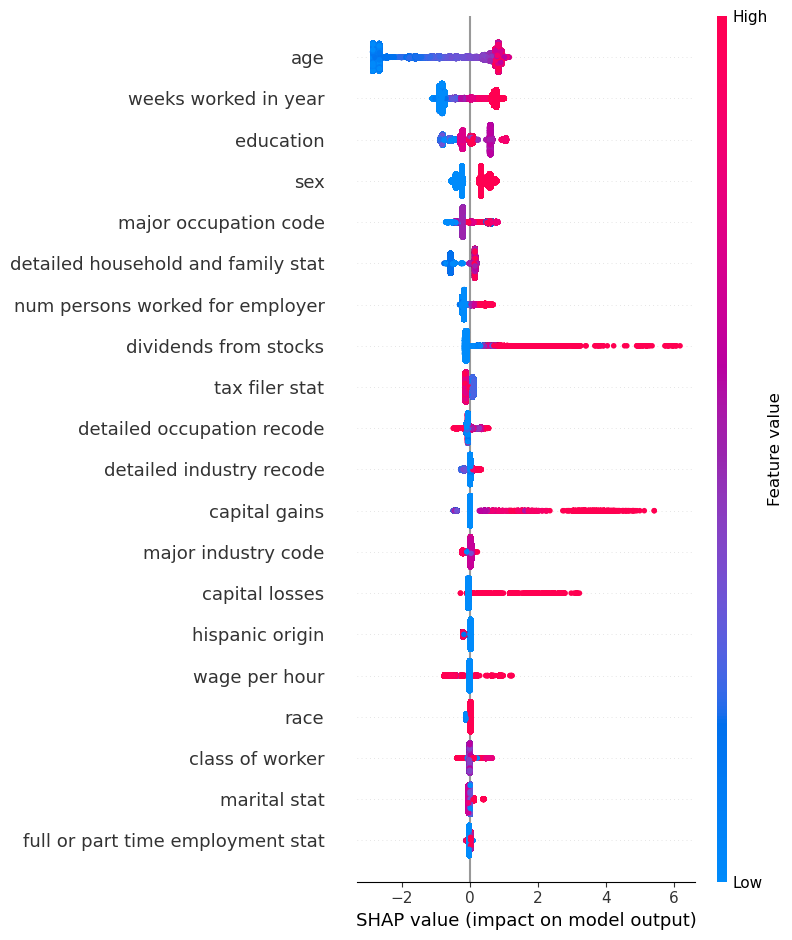

In [13]:
shap.summary_plot(shap_values, X_test_encoded, feature_names=X_test_encoded.columns)

<Figure size 640x480 with 0 Axes>

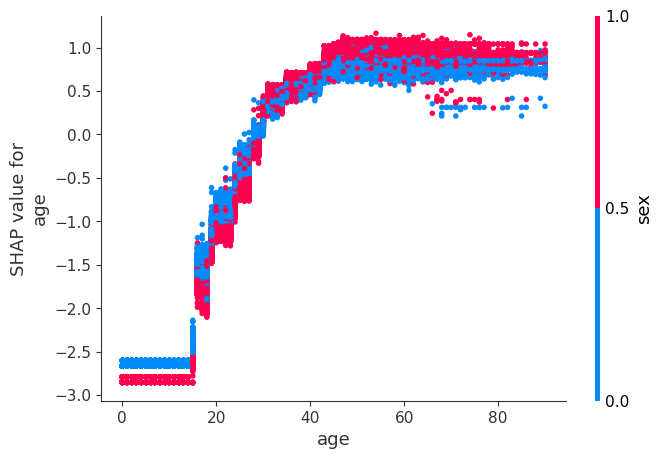

<Figure size 640x480 with 0 Axes>

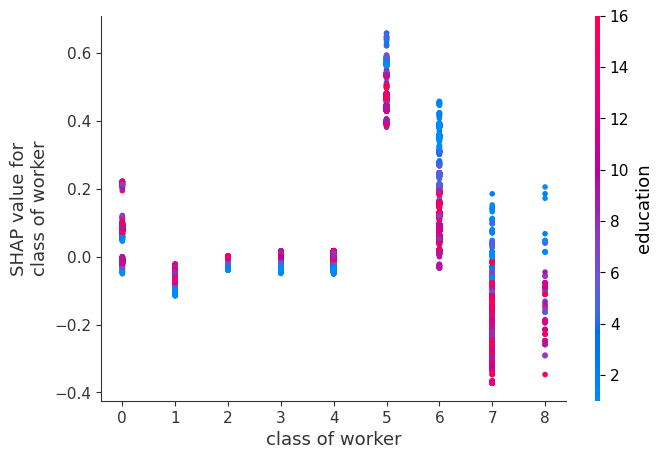

<Figure size 640x480 with 0 Axes>

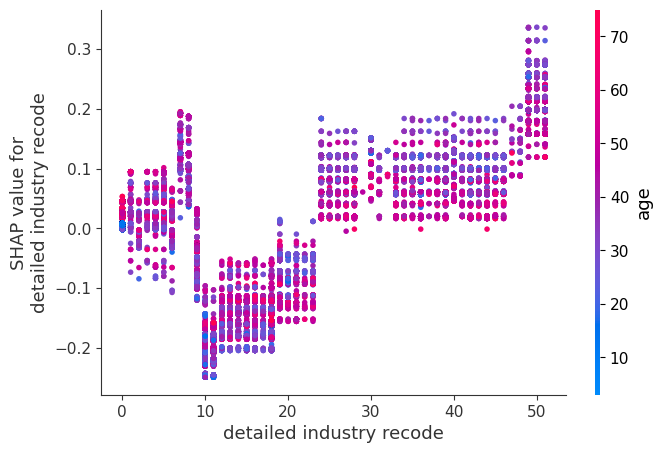

<Figure size 640x480 with 0 Axes>

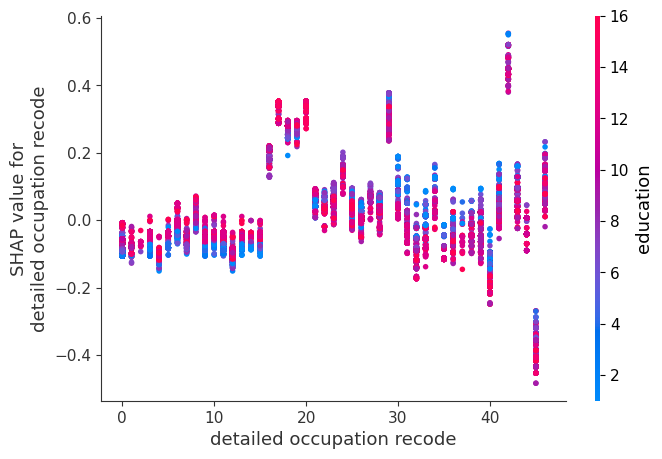

<Figure size 640x480 with 0 Axes>

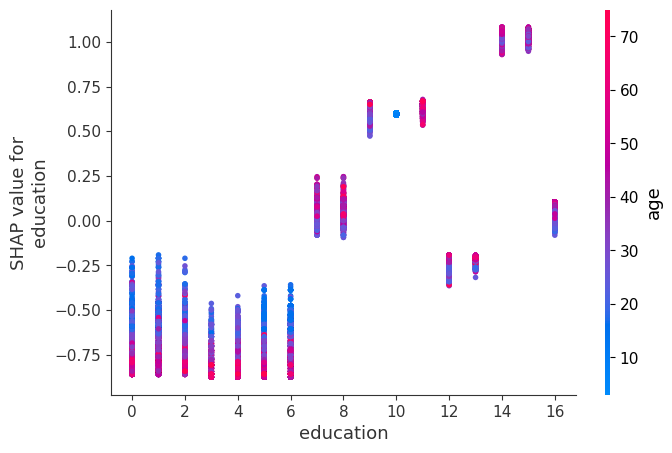

<Figure size 640x480 with 0 Axes>

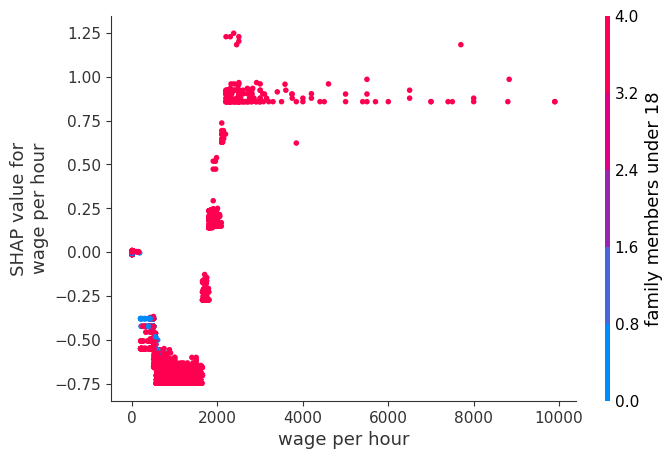

<Figure size 640x480 with 0 Axes>

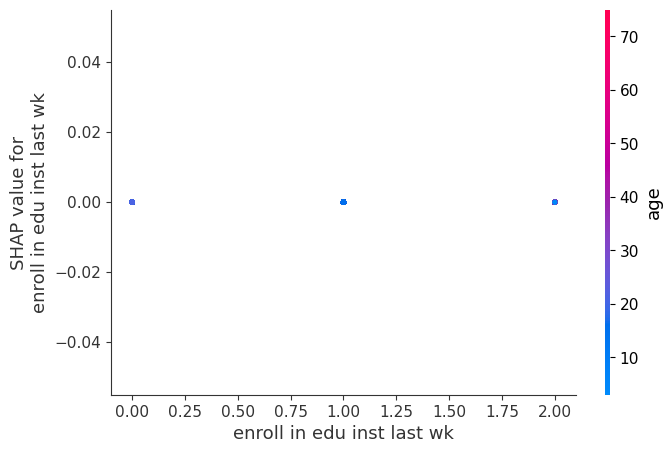

<Figure size 640x480 with 0 Axes>

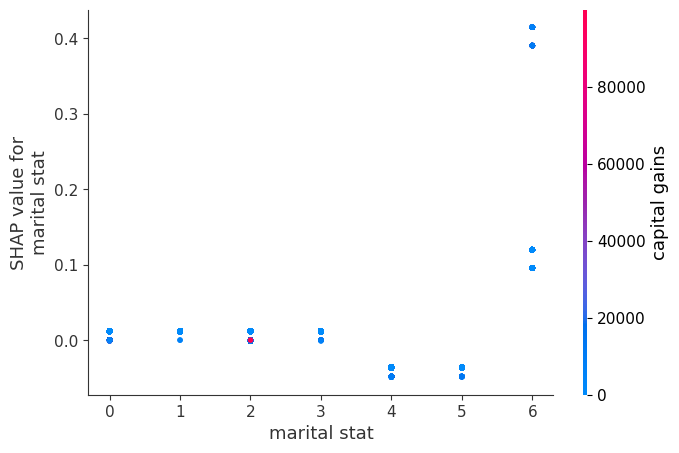

<Figure size 640x480 with 0 Axes>

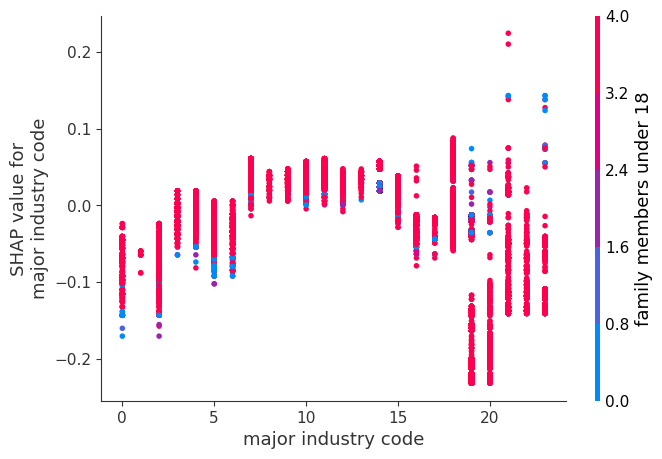

<Figure size 640x480 with 0 Axes>

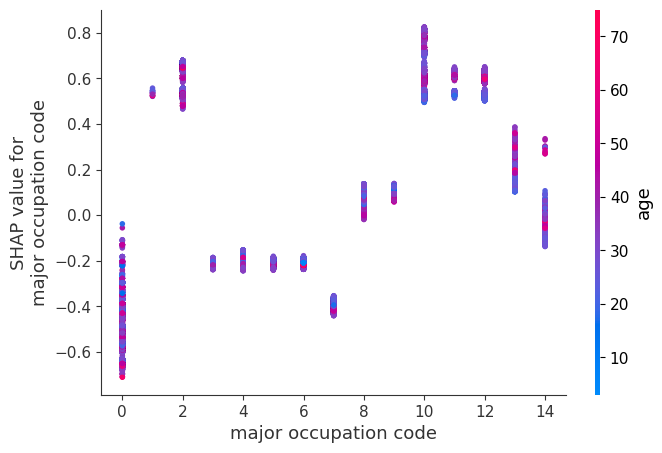

<Figure size 640x480 with 0 Axes>

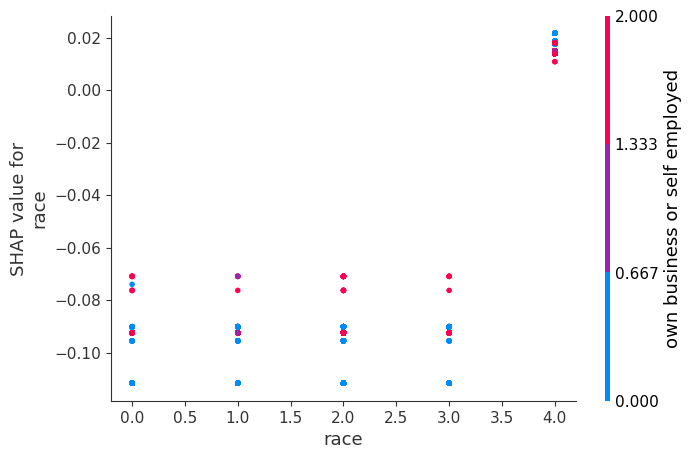

<Figure size 640x480 with 0 Axes>

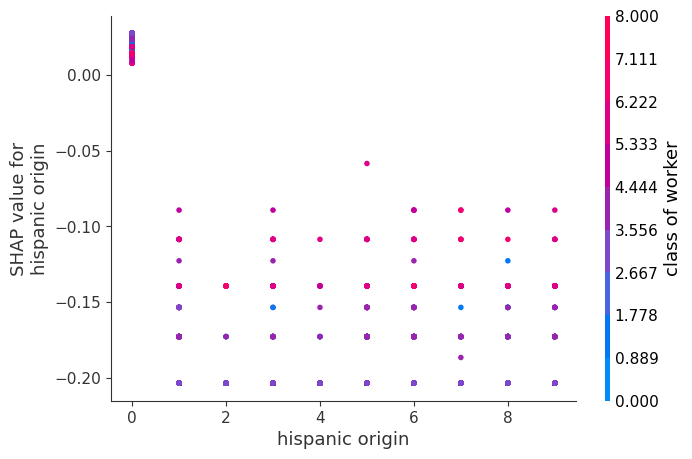

<Figure size 640x480 with 0 Axes>

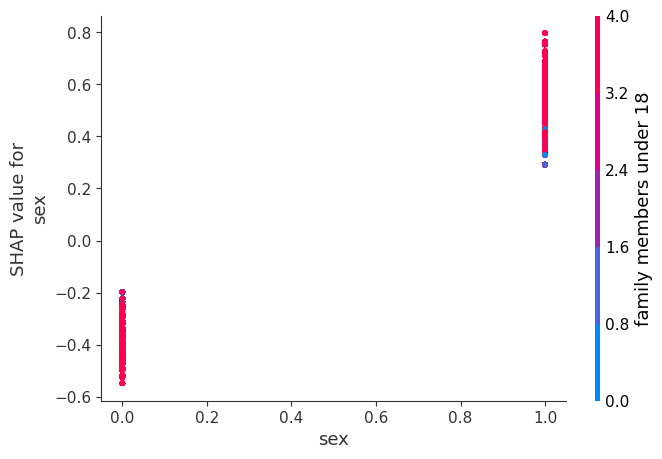

<Figure size 640x480 with 0 Axes>

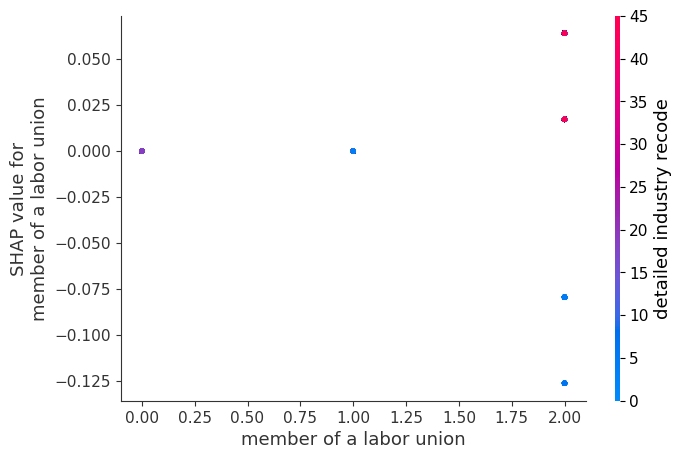

<Figure size 640x480 with 0 Axes>

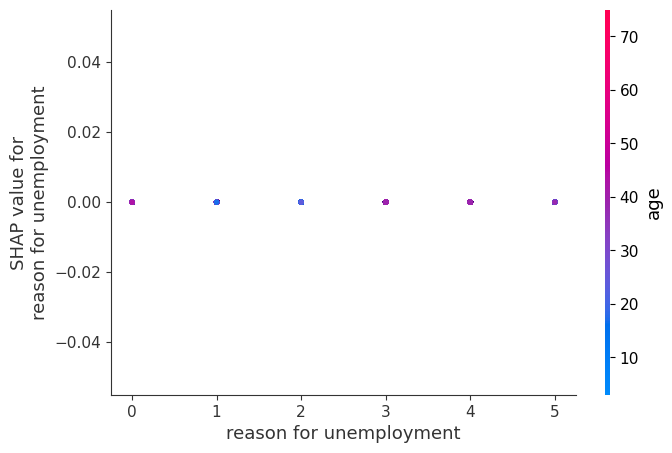

<Figure size 640x480 with 0 Axes>

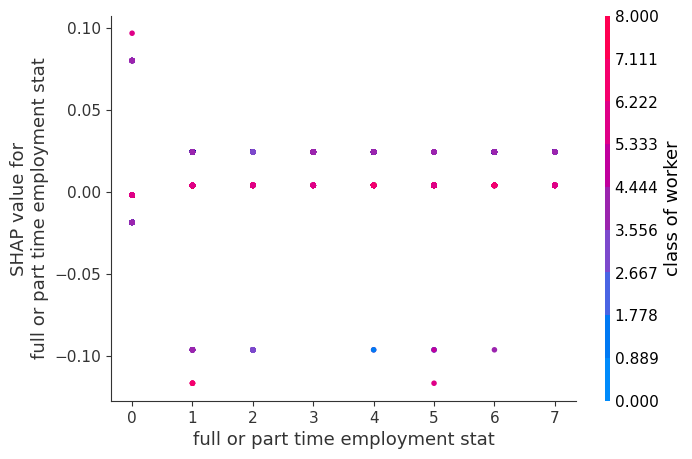

<Figure size 640x480 with 0 Axes>

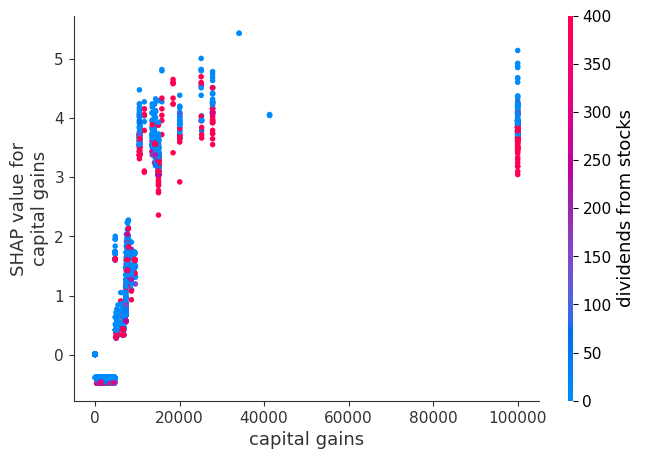

<Figure size 640x480 with 0 Axes>

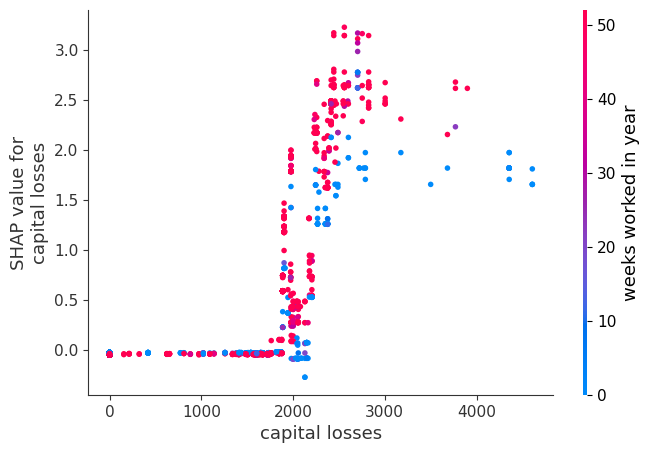

<Figure size 640x480 with 0 Axes>

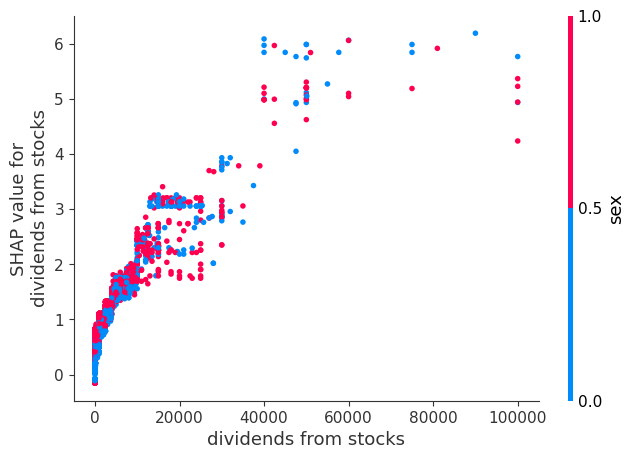

<Figure size 640x480 with 0 Axes>

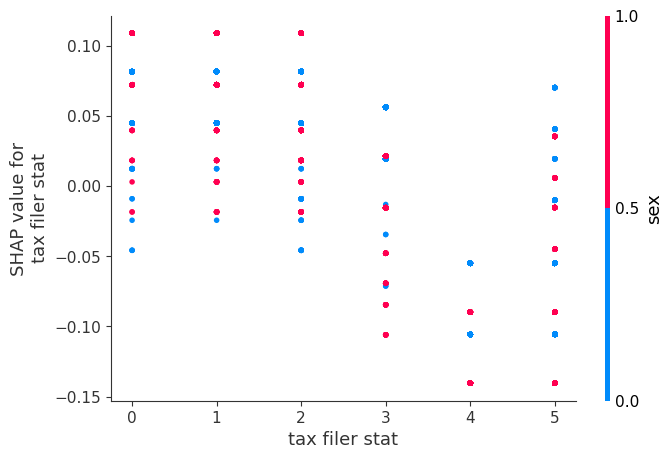

<Figure size 640x480 with 0 Axes>

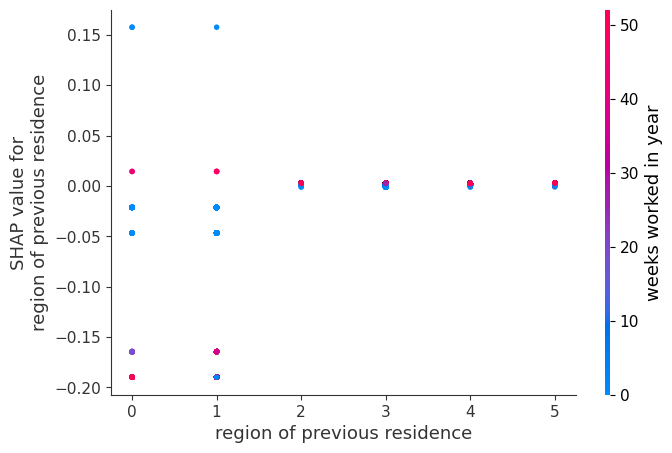

<Figure size 640x480 with 0 Axes>

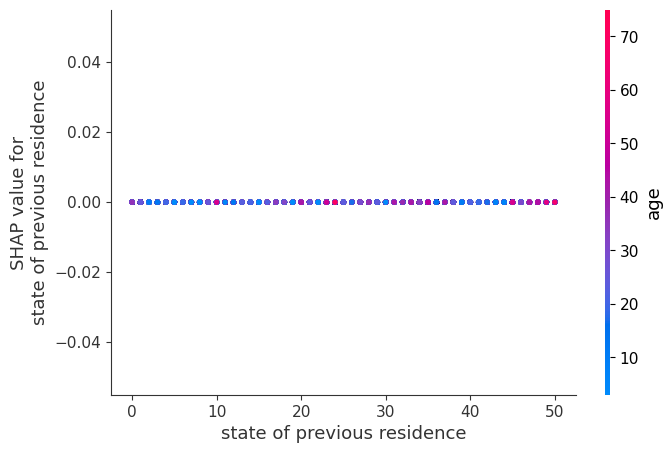

<Figure size 640x480 with 0 Axes>

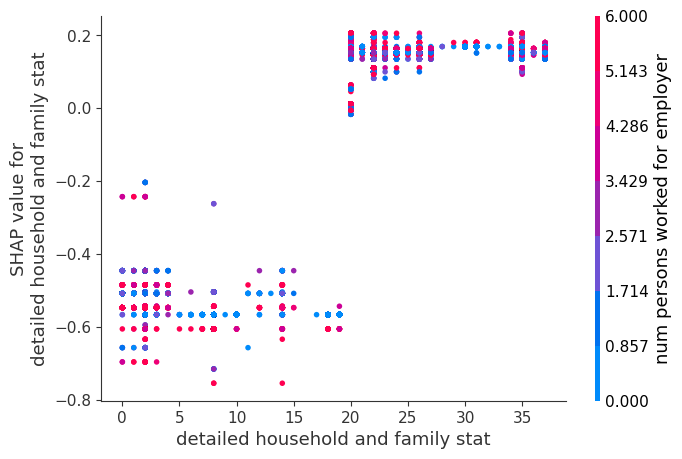

<Figure size 640x480 with 0 Axes>

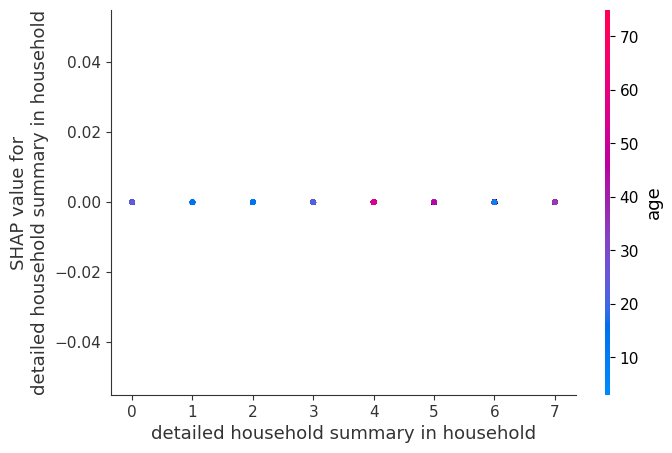

<Figure size 640x480 with 0 Axes>

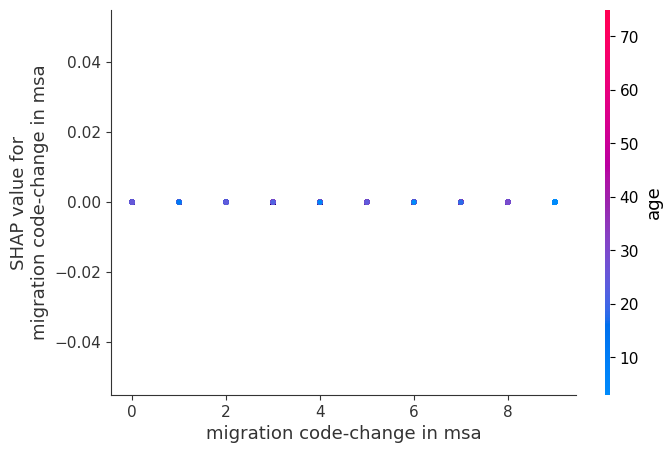

<Figure size 640x480 with 0 Axes>

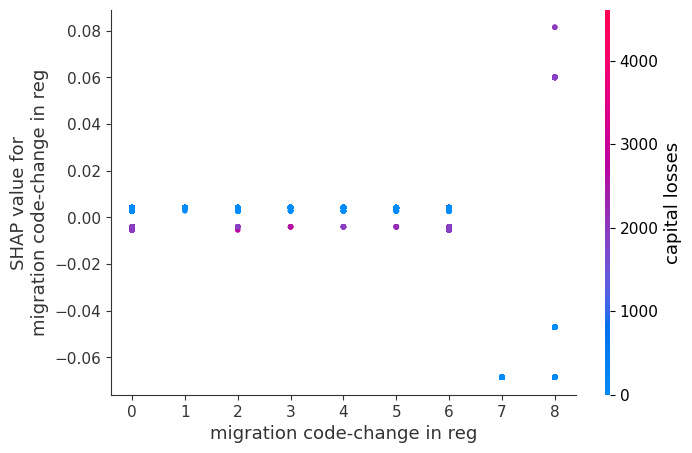

<Figure size 640x480 with 0 Axes>

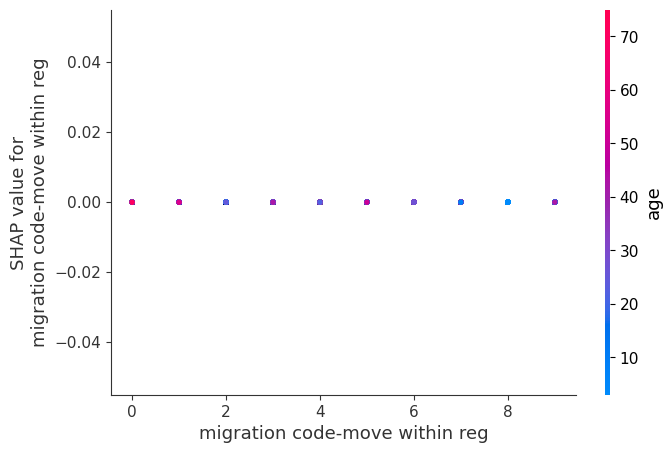

<Figure size 640x480 with 0 Axes>

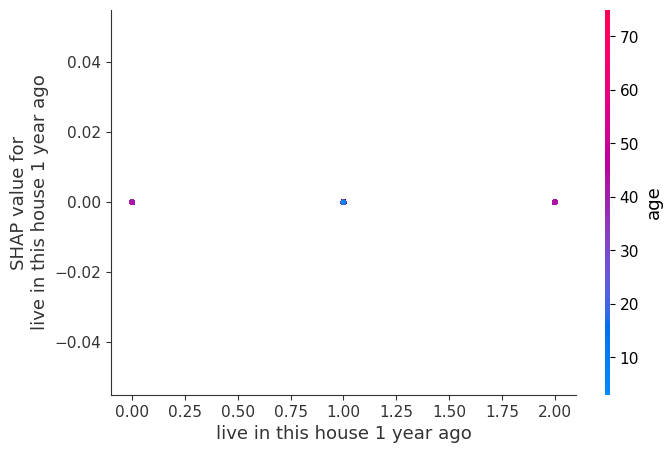

<Figure size 640x480 with 0 Axes>

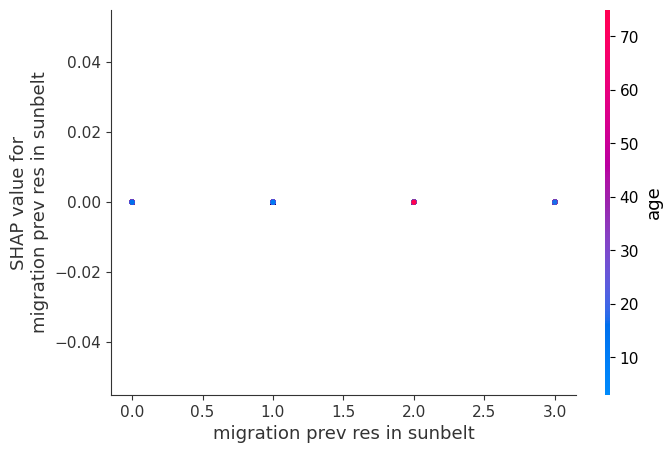

<Figure size 640x480 with 0 Axes>

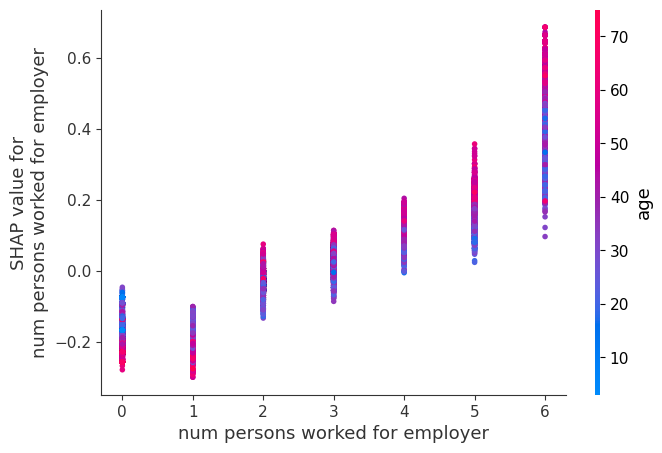

<Figure size 640x480 with 0 Axes>

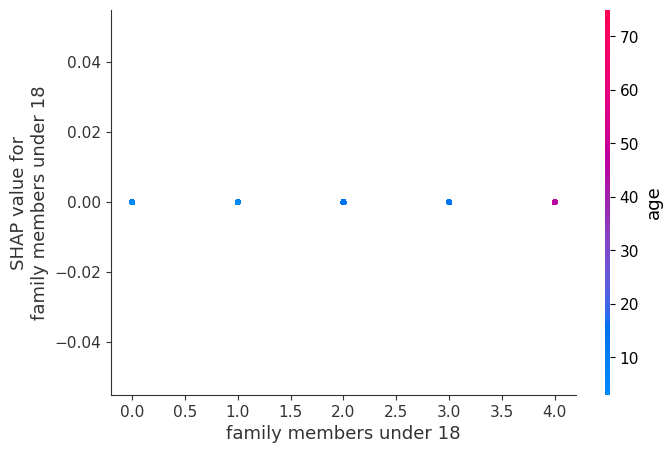

<Figure size 640x480 with 0 Axes>

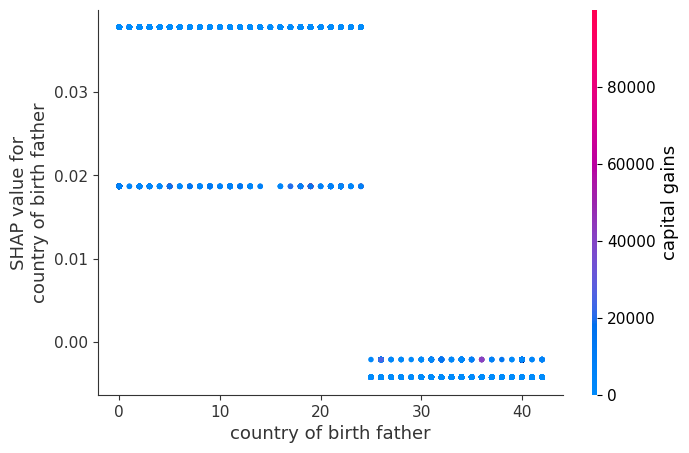

<Figure size 640x480 with 0 Axes>

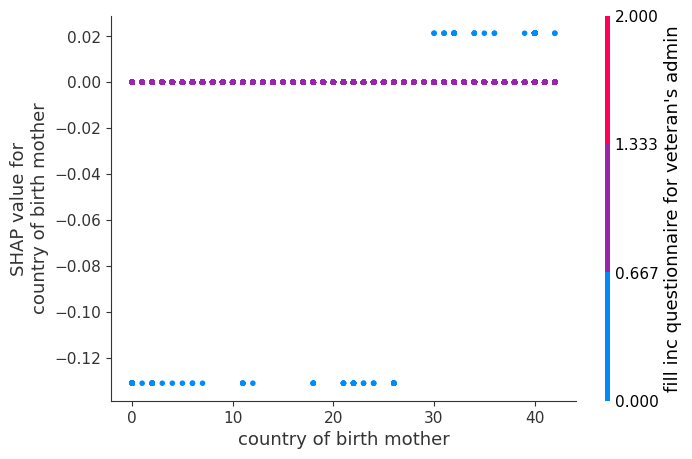

<Figure size 640x480 with 0 Axes>

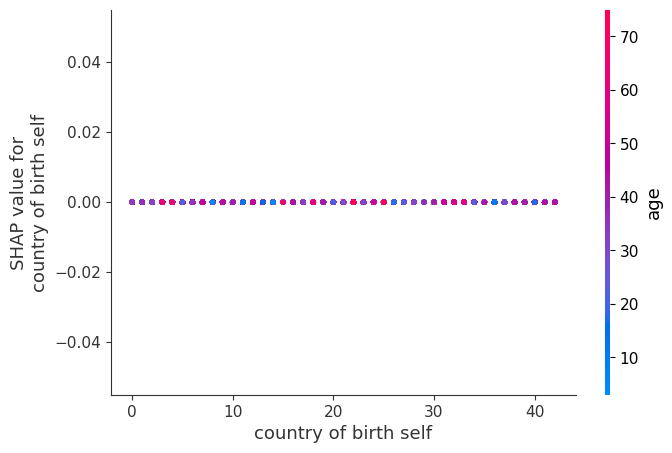

<Figure size 640x480 with 0 Axes>

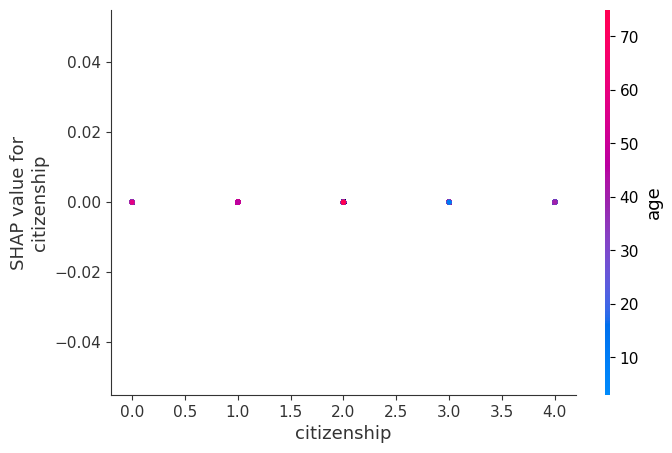

<Figure size 640x480 with 0 Axes>

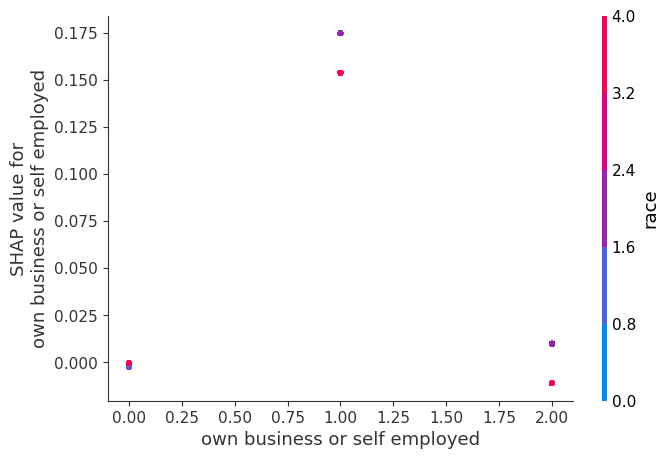

<Figure size 640x480 with 0 Axes>

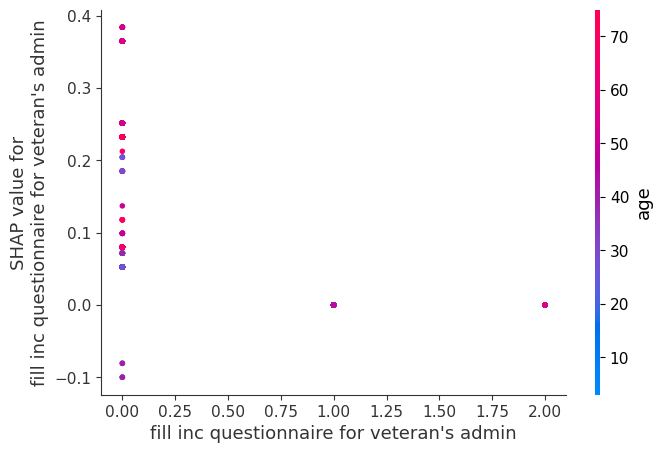

<Figure size 640x480 with 0 Axes>

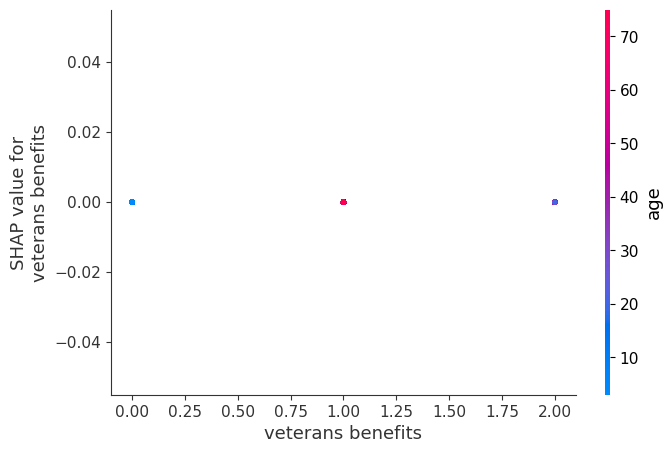

<Figure size 640x480 with 0 Axes>

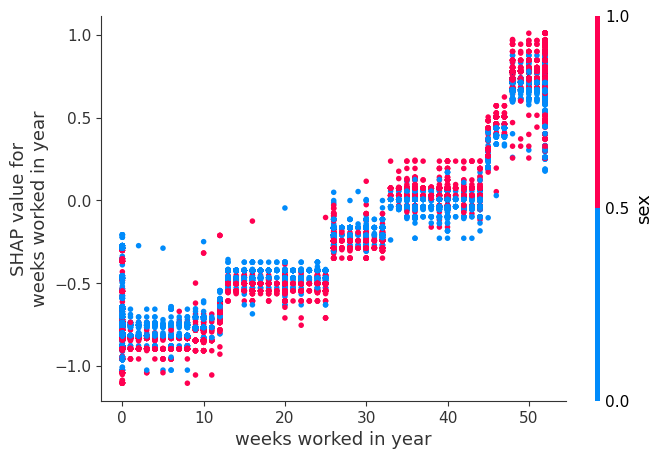

<Figure size 640x480 with 0 Axes>

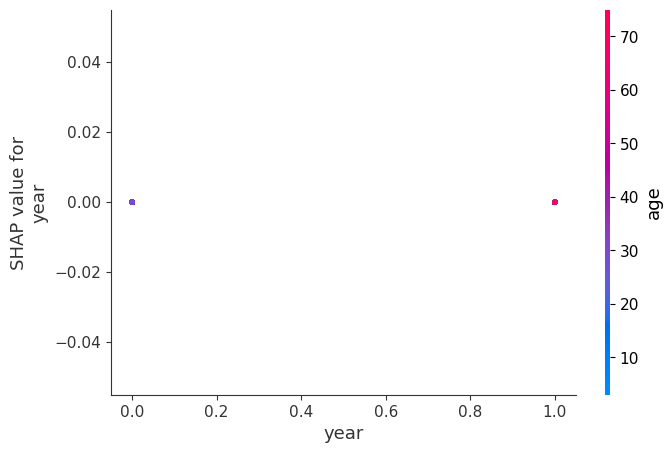

In [14]:
for i in range(X_test.shape[1]):
    plt.figure()
    shap.dependence_plot(i, shap_values.values, X_test_encoded)
    plt.show()

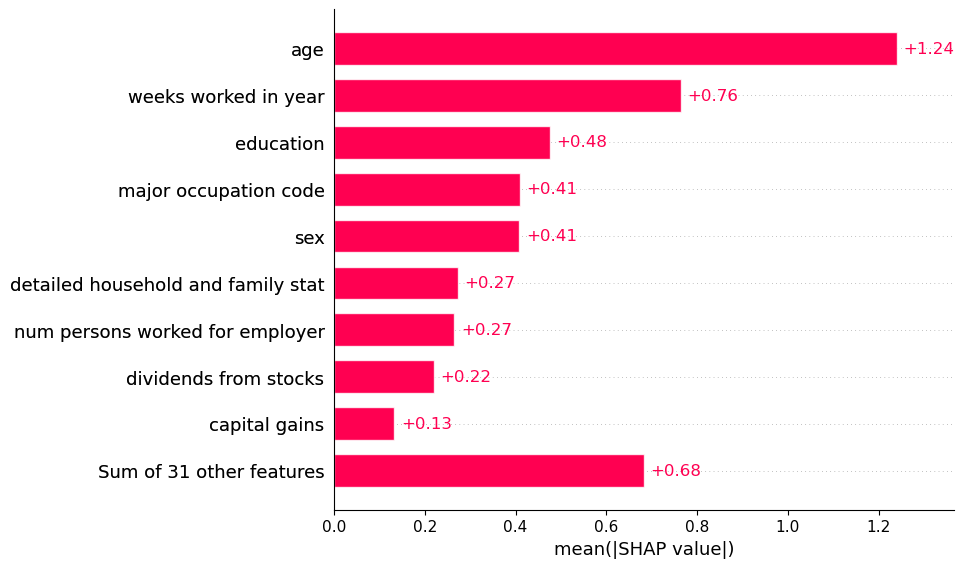

In [15]:
shap.plots.bar(independent_shap_values, max_display=10)

In [16]:
feature_names = X_test_encoded.columns

# print(shap_interaction_values.shape)
mean_interaction_values = np.mean(np.abs(shap_interaction_values), axis=0)
# print(mean_interaction_values.shape)

# Create array filled with ones.
ones = np.ones(mean_interaction_values.shape)
# print(ones)

# Elements below the k-th diagonal zeroed.
triu = np.triu(ones, k=1)
# print(triu)

interaction_df = pd.DataFrame(mean_interaction_values, columns=feature_names, index=feature_names)

series = interaction_df.where(triu.astype(bool)).stack()
# print(series)

interaction_df = series.reset_index()
# display(interaction_df)

interaction_df.columns = ["Feature 1", "Feature 2", "Interaction Value"]
interaction_df.sort_values(by="Interaction Value", ascending=False).head(20)

,Feature 1,Feature 2,Interaction Value
11,age,sex,0.061188
427,sex,weeks worked in year,0.037769
119,detailed occupation recode,major occupation code,0.037636
3,age,education,0.033976
37,age,weeks worked in year,0.027531
28,age,num persons worked for employer,0.027390
77,detailed industry recode,detailed occupation recode,0.017252
408,sex,tax filer stat,0.017128
407,sex,dividends from stocks,0.015350
82,detailed industry recode,major industry code,0.014796


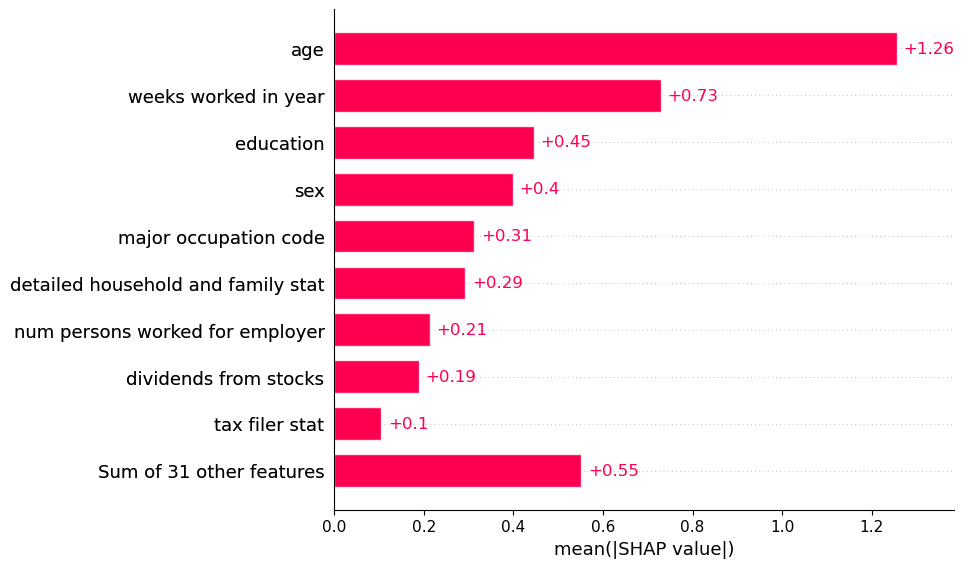

In [17]:
shap.plots.bar(shap_values, max_display=10)

In [18]:
fp = (y_test_predictions == 1) & (y_test_encoded == 0)
shap_values_tp = shap_values[(y_test_predictions == 1) & (y_test_encoded == 1)]
shap_values_fp = shap_values[fp]
shap_values_tn = shap_values[(y_test_predictions == 0) & (y_test_encoded == 0)]
shap_values_fn = shap_values[(y_test_predictions == 0) & (y_test_encoded == 1)]


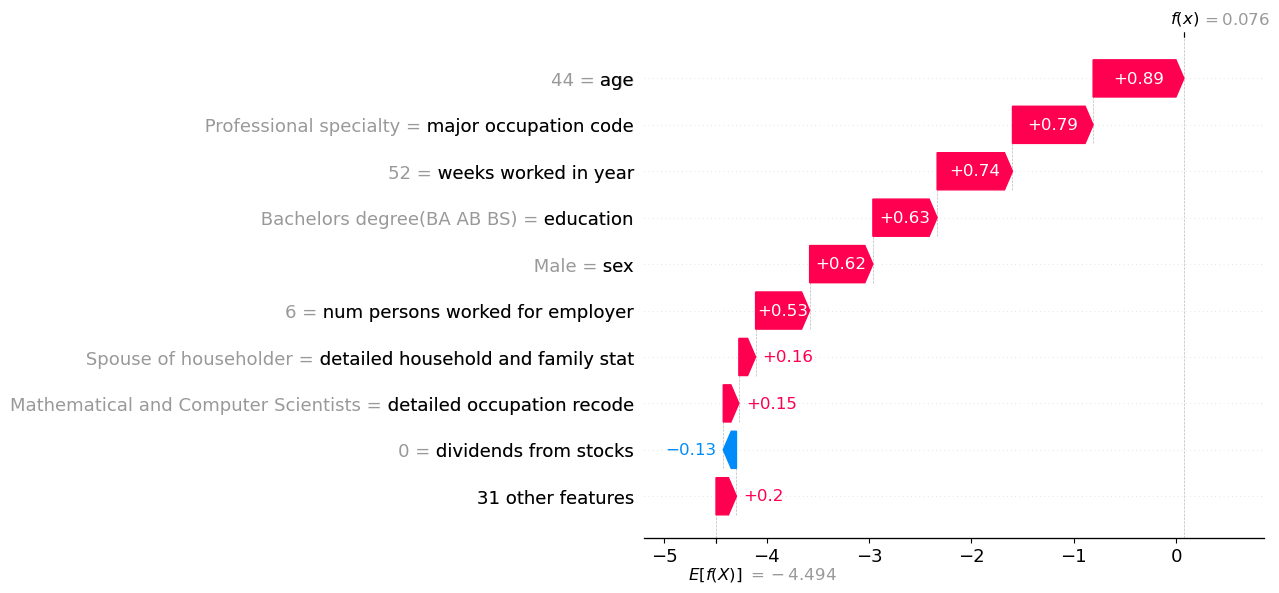

In [19]:
shap_values_fp.data = X_test[fp].values
shap.plots.waterfall(shap_values_fp[600], max_display=10)
shap_values_fp.data = X_test_encoded[fp].values

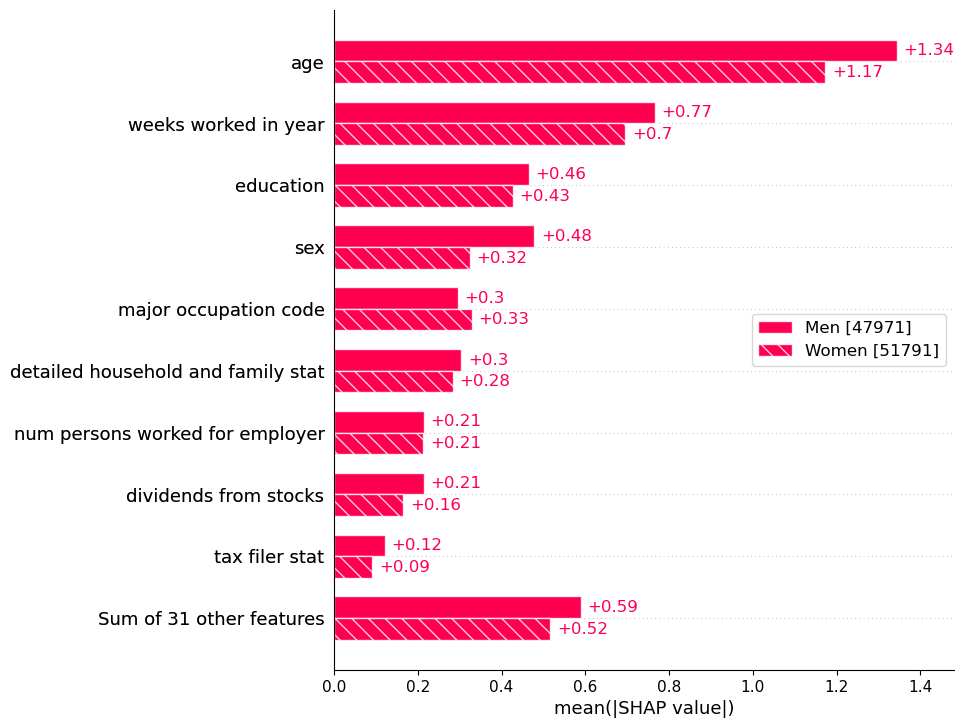

In [20]:
sex = ["Women" if shap_values[i, "sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

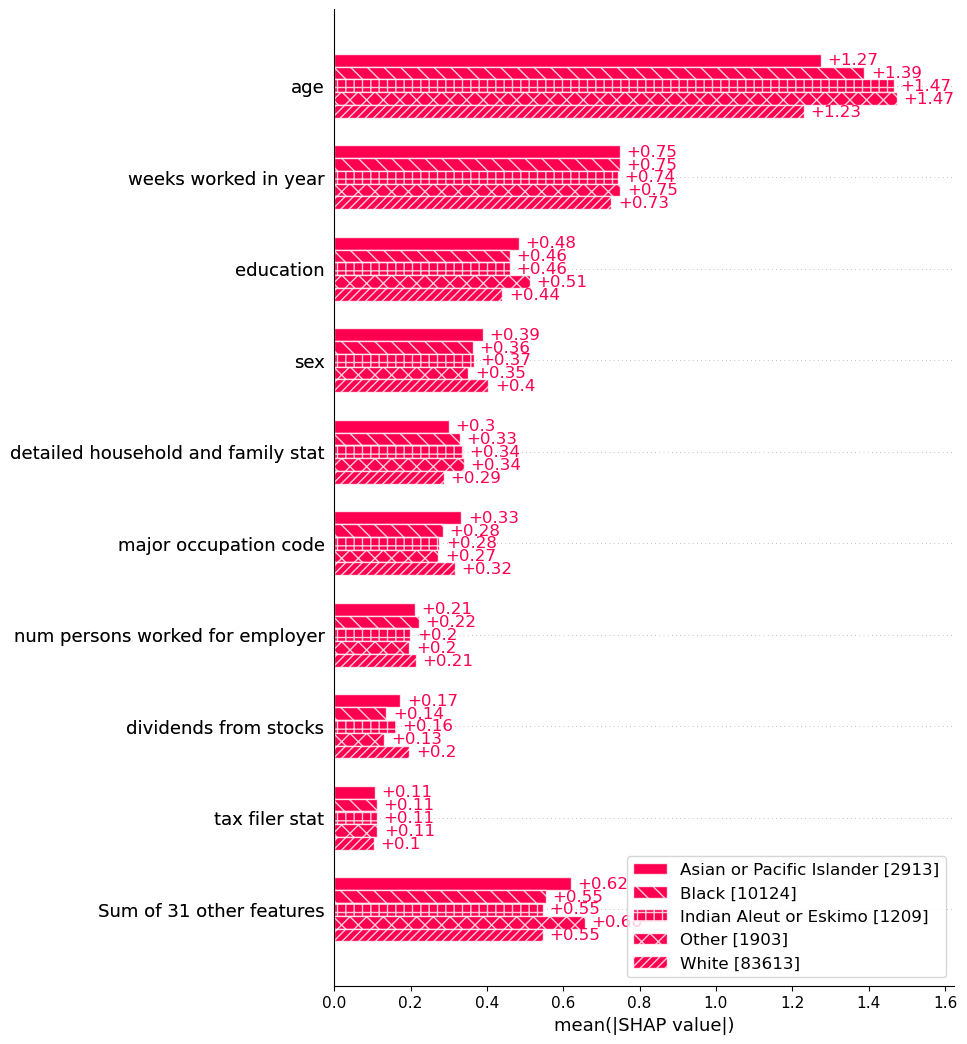

In [21]:
race = [
    "White" if shap_values[i, "race"].data == 4 else
    "Black" if shap_values[i, "race"].data == 2 else
    "Asian or Pacific Islander" if shap_values[i, "race"].data == 1 else
    "Other" if shap_values[i, "race"].data == 3 else
    "Indian Aleut or Eskimo"
    for i in range(shap_values.shape[0])
]

shap.plots.bar(shap_values.cohorts(race).abs.mean(0))

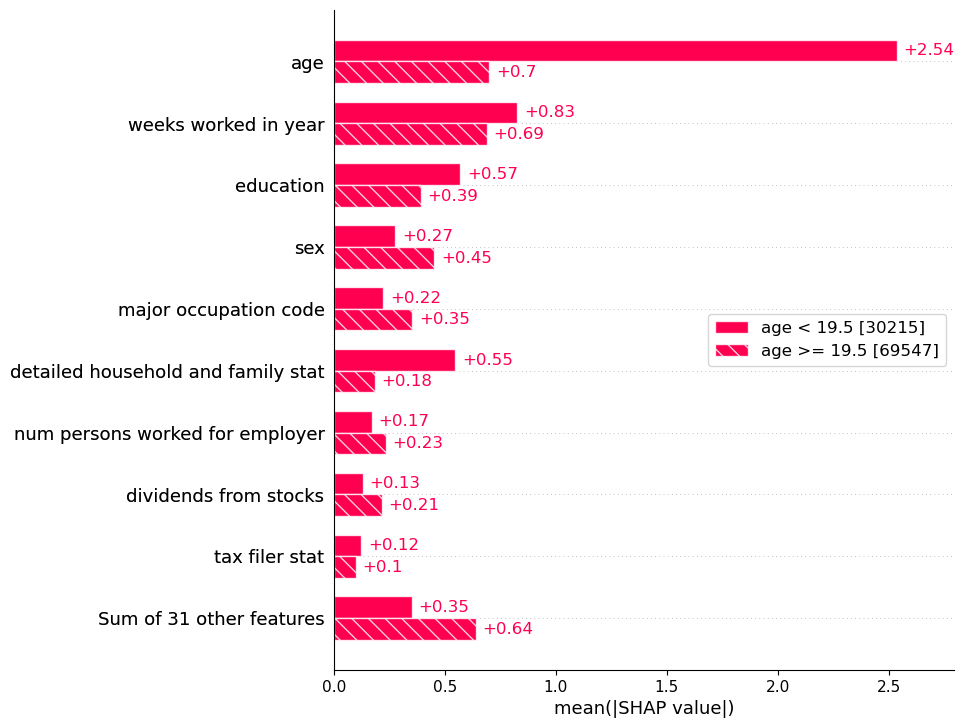

In [22]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [23]:
# Xf = X_train_encoded[X_train_encoded["age"] > 19]
# yf = y_train_encoded[X_train_encoded["age"] > 19]
# Xf_test = X_test_encoded[X_test_encoded["age"] > 19]

# model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(Xf, yf)

# explainerf = shap.Explainer(model, Xf)
# shap_valuesf = explainer(Xf_test)

# shap.plots.bar(shap_valuesf.cohorts(2).abs.mean(0))


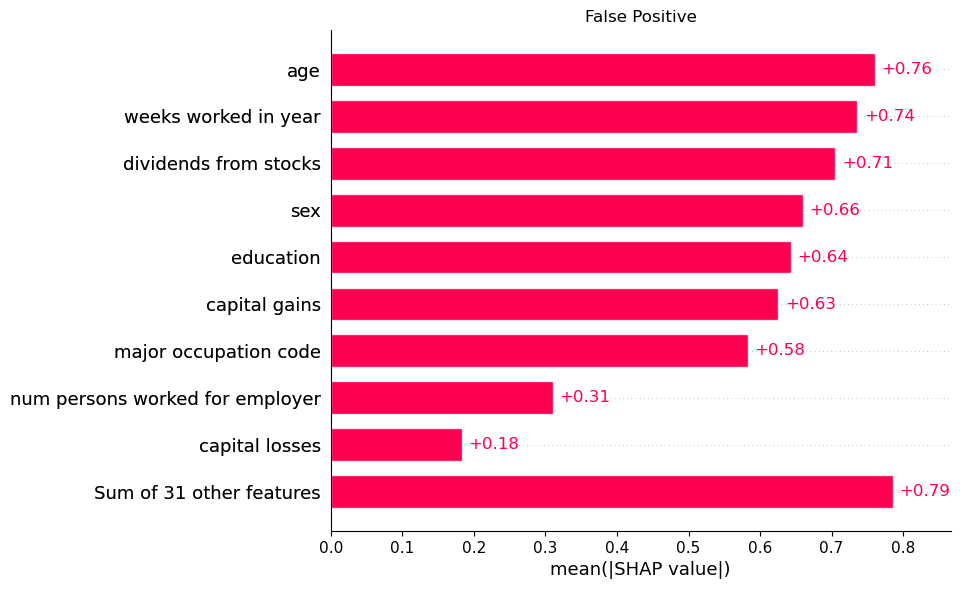

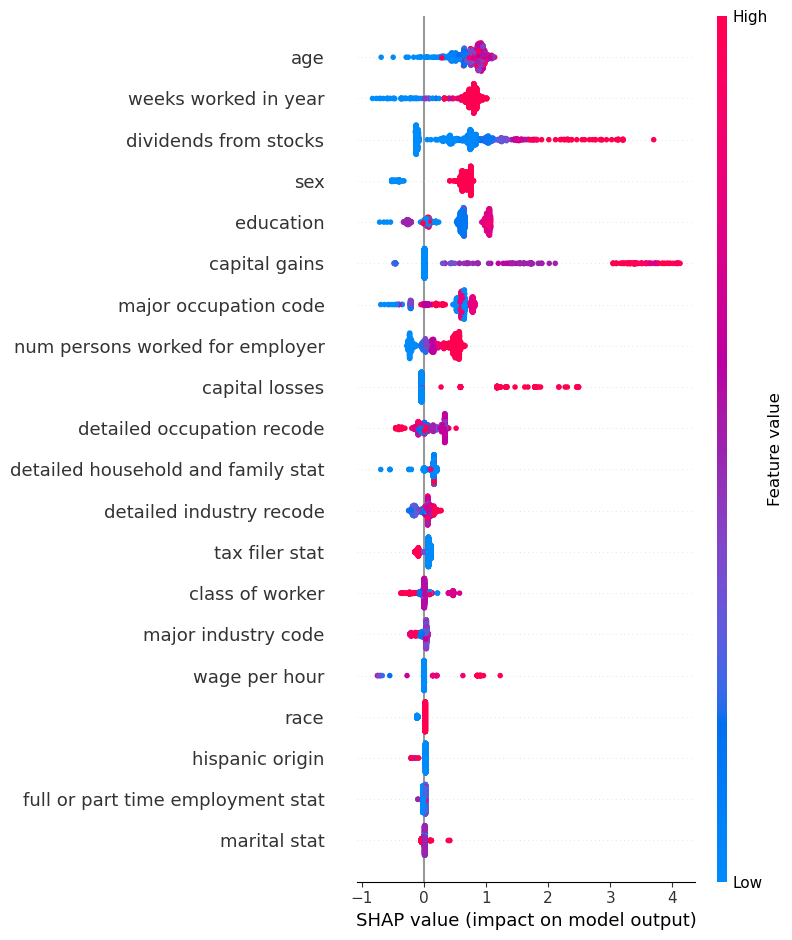

In [24]:
shap.plots.bar(shap_values_fp, max_display=10, show=False)
plt.title('False Positive')
plt.savefig('../results/shap_fp.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
shap.summary_plot(shap_values_fp)


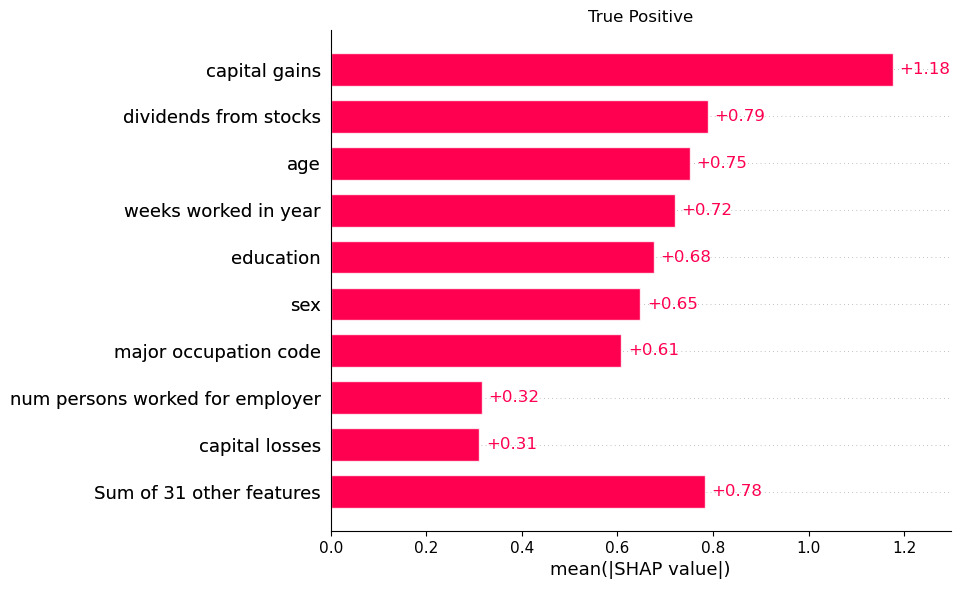

In [25]:
shap.plots.bar(shap_values_tp, max_display=10, show=False)
plt.title('True Positive')
plt.savefig('../results/shap_tp.png', format='png', dpi=300, bbox_inches='tight')

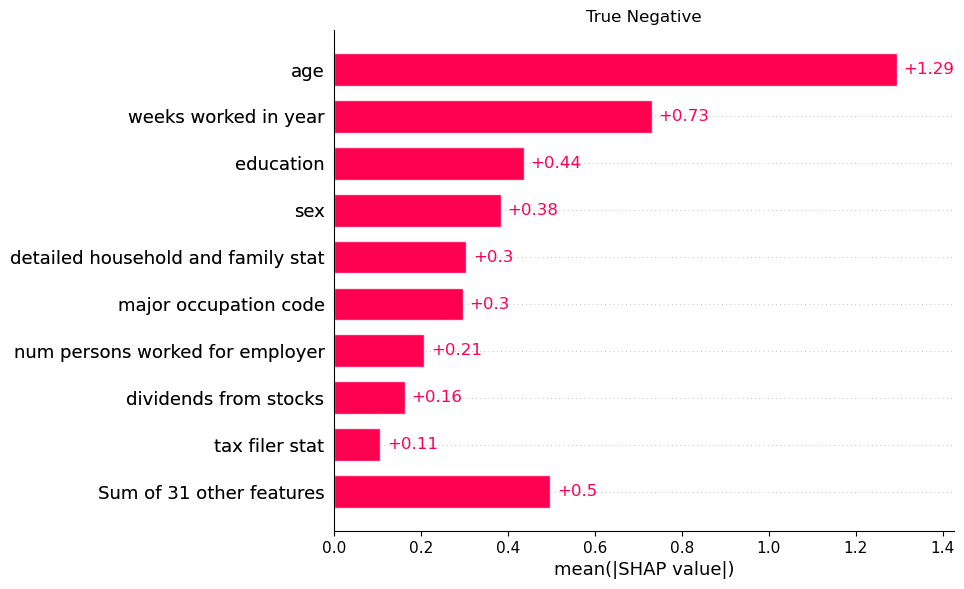

In [26]:
shap.plots.bar(shap_values_tn, max_display=10, show=False)
plt.title('True Negative')
plt.savefig('../results/shap_tn.png', format='png', dpi=300, bbox_inches='tight')

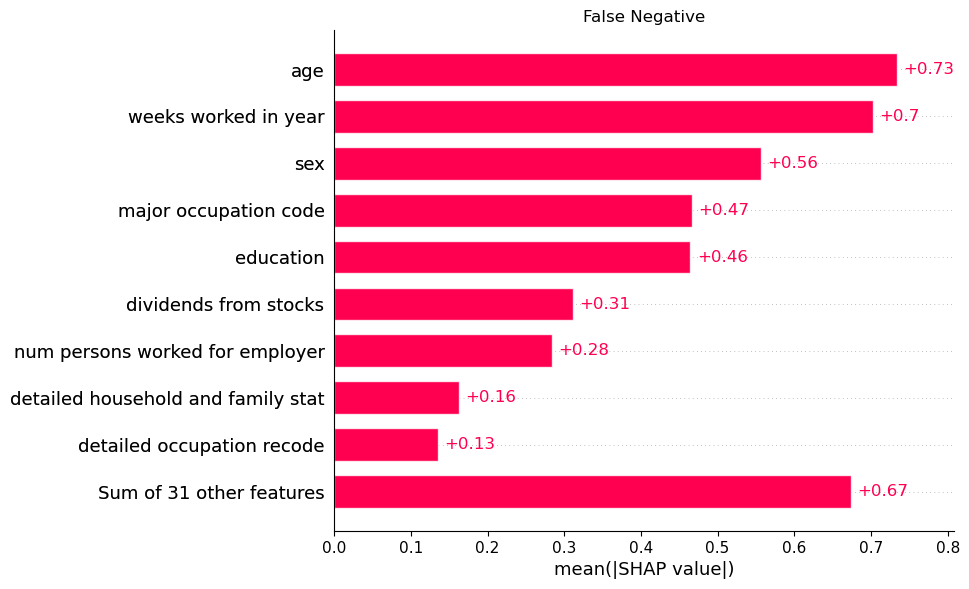

In [27]:
shap.plots.bar(shap_values_fn, max_display=10, show=False)
plt.title('False Negative')
plt.savefig('../results/shap_fn.png', format='png', dpi=300, bbox_inches='tight')